https://mset.space - платформа для проведения анализа данных, построения моделей и внедрения моделей в продукцию.


https://mset.space - platform for data analysis, model building and implementation into production.


Ноутбуки для платформы mset.space
https://github.com/MindSetLib/MS-Education

Low code ML - библиотека машинного обучения
https://github.com/MindSetLib/Insolver


Телеграм канал платформы
https://t.me/msetspace

Связь с разработчиками:
telegram: @frankshikhaliev
email: request@mind-set.ru

# Tweedie
В этом ноутбуке будут рассмотрены статистические библиотеки, которые могут быть применены в сфере страхования:

*   [Statsmodels](https://www.statsmodels.org/dev/index.html)
*   [Scipy](https://github.com/scipy/scipy/)
*   [Tweedie](https://github.com/thequackdaddy/tweedie)








### Введение

Страховые компании не знают действительную стоимость своего продукта, т.к. они имеют дело с рисками непредвиденных событий. Ответ на данный вопрос они ищут в математике.

Хотелось бы имея определенные параметры застрахованного объекта, оценить возможную стоимость страховой выплаты. Т.к. страховые случаи возникают редко, большинство наблюдений имеют нулевые выплаты.

Поэтому распределение целевой переменной имеет большую концентрацию в нуле и положительно определенное, похожее на нормально распределение справа от нуля. Такое распределение называется Tweedia. Это распределение интересно тем, что оно обеспечивает множество других распределений от гауссовского к обратному Гауссову, просто изменяя один параметр.

Распределение Tweedia является частным случаем экспоненциальных дисперсионных моделей [exponential dispersion models (EDM)](https://en.wikipedia.org/wiki/Exponential_dispersion_model), которые в свою очередь являются набором вероятностных распределений, представляющих собой обобщение естественного экспоненциального семейства.

Оно имеет много наблюдений в нуле, и это свойство делает его полезным для моделирования претензий в страховой отрасли.




Гистограмма Tweedie распределения

![Гистограмма](https://s8.hostingkartinok.com/uploads/images/2020/11/0de6d812050f13ab7e45ba0ca59e2300.png)

Это семейство распределений имеет следующие характеристики

$E(Y) = \mu$ 

$Var(Y) = \phi\mu^p$

$Y \sim Tw_p(\mu, \phi)$, где

$Y$ - это целевая переменная
 
$Tw_p(\mu, \phi)$ - случайная величина из распределения Tweedie, со средним $\mu$ и дисперсией $\phi \mu^p$, где $\phi > 0$ и $p \in (- \infty, 0] \cup [1, \infty)$

$p$ является регулируемым параметром

Используя распределение Tweedie, можно апроксимировать другие распределения. Поставим $p = 0$, получим нормальное распределение, поставим $p = 1$, получим распределение Пуассона, поставим $p = 2$, получим гамма распределение, а если $p = 3$, получим обратное Гауссовское распределение.

![](https://s8.hostingkartinok.com/uploads/images/2020/11/591ae0e9bcc512e727d75c50fac9b3a8.png)



Рассмотрим на реальном датасете, как можно построить модель для распределения Tweedie.

Установим необходимую библиотеку

Из этой библиотеки возьмем функцию правдоподобия для Tweedie распределения

In [ ]:
!pip install tweedie

Импортируем модули

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


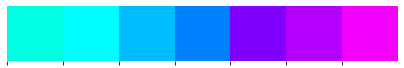

In [ ]:
%matplotlib inline
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from tweedie import tweedie

from sklearn.metrics import r2_score

from statsmodels.compat import lzip
from statsmodels.graphics.api import abline_plot
from statsmodels.genmod.generalized_linear_model import GLM

#plt.style.use('fivethirtyeight')

# Color Palette
custom_colors = ['#00FFE2', '#00FDFF', '#00BCFF', '#0082FF', '#8000FF', '#B300FF', '#F400FF']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

### Анализ данных

Воспользуемся датасетом: https://rdrr.io/cran/insuranceData/man/dataCar.html

Этот набор данных основан на страховых полисах на один год, заключенных в 2004 или 2005 годах.

In [ ]:
!wget http://www.businessandeconomics.mq.edu.au/__data/assets/file/0011/232310/car.csv

--2020-11-17 18:13:08--  http://www.businessandeconomics.mq.edu.au/__data/assets/file/0011/232310/car.csv
Resolving www.businessandeconomics.mq.edu.au (www.businessandeconomics.mq.edu.au)... 202.9.95.188
Connecting to www.businessandeconomics.mq.edu.au (www.businessandeconomics.mq.edu.au)|202.9.95.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘car.csv’

car.csv                 [               <=>  ]   3.90M  1.22MB/s    in 4.4s    

2020-11-17 18:13:13 (916 KB/s) - ‘car.csv’ saved [4090262]



***Данный датасет содержит 67856 наблюдений и 11 переменных:***

**`veh_value`**: стоимость транспортного средства (в $10,000)

**`exposure`**: на какой срок полис был выставлен (1 - на год)

**`clm`**: возникновение претензий (0 = нет, 1 = да)

**`numclaims`**: количество претензий

**`claimcst0`**: сумма иска (0 если нет претензий)

**`veh_body`**: кузов транспортного средства. `BUS` `CONVT` `COUPE` `HBACK` `HDTOP` `MCARA` `MIBUS` `PANVN` `RDSTR` `SEDAN` `STNWG` `TRUCK` `UTE`

**`veh_age`**: возраст транспорого средства

**`gender`**: `F` - жинщина, `M` - мужчина

**`area`**: `A` `B` `C` `D` `E` `F`

**`agecat`**: возрастная категория водителя (1, 2, 3, 4, 5, 6)

**`_OBSTAT_`**

In [ ]:
df = pd.read_csv('car.csv')
df.head(3)

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,_OBSTAT_
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2,01101 0 0 0
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4,01101 0 0 0
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2,01101 0 0 0


Удалим дубликаты и строчки, где стоимость транспортного средства равна 0

In [ ]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape)

number of duplicate rows: (378, 11)


In [ ]:
df1 = df.drop_duplicates()     # удалим дубликаты
df2 = df1[df1.veh_value != 0]  # удалим данные, где стоимость транспортного средства равна 0

Посмотрим на данные, подходят ли они под Tweedie распределение?

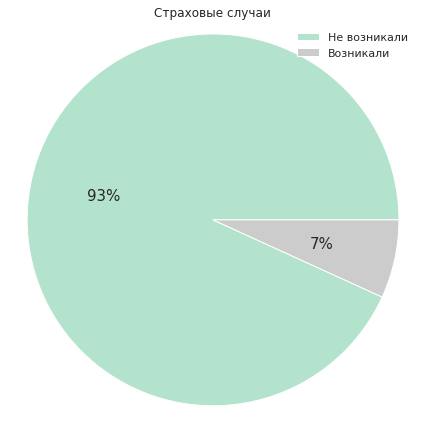

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 6)) # инициализируем полотно
df['clm'].value_counts().plot(kind='pie', labels=['', ''],
                                  ax=ax, autopct='%.0f%%', fontsize=15, colormap='Pastel2') # построим круговую диаграмму
ax.set_title(u'Страховые случаи')
ax.axis('equal')
ax.legend(labels=[u'Не возникали', u'Возникали'], framealpha=0, fontsize = 11)
ax.set_ylabel('')
plt.tight_layout()

Видим, что претензии к страховой компании возникали только в 7% случаев.

Посмотрим как распределено количество страховых случаев

<class 'matplotlib.patches.Rectangle'>


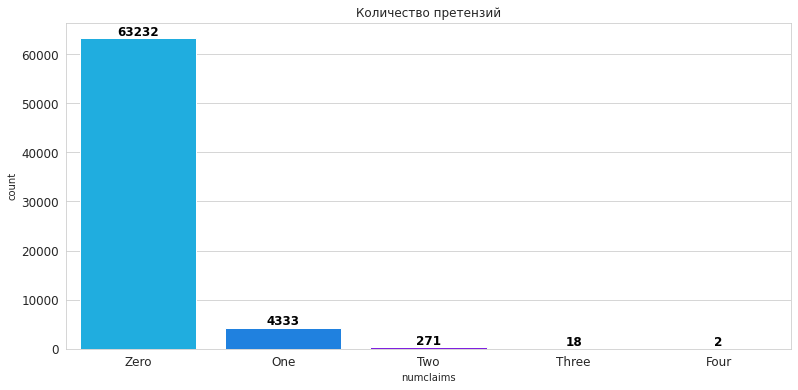

In [ ]:
order = ['Zero', 'One', 'Two', 'Three', 'Four'] # подписи оси X

plt.figure(figsize=(13, 6)) # установить размер полотна
d = sns.countplot(x = 'numclaims', data = df, palette = custom_colors[2:] ) # построить столбчатую диаграмму
d.set_xticklabels(order, rotation=0) # подписать ось X
d.set_title('Количество претензий')

labels = df.numclaims.value_counts().to_list() # посчитаем количество наблюдейни в каждом столбце

# вывести кол-во над столбцами
def labels_above_columns(labels):
  rects = d.patches # объект столбцов https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Rectangle.html
  for rect, label in zip(rects, labels):
      height = rect.get_height() 
      d.text(rect.get_x() + rect.get_width() / 2, height + 5, label, color='black', 
              ha='center', va='bottom', fontweight='bold', fontsize = 12)

labels_above_columns(labels)

Посмотрим как распределены страховые выплаты.

In [ ]:
# распределить наблюдения по указанным интервалам
def condition(x):
    if x == 0:
        return 0
    elif 0 < x <= 500:
        return 1
    elif 500 < x <= 1000:
        return 2
    elif 1000 < x <= 2000:
        return 3
    elif 2000 < x <= 5000:
        return 4
    elif 5000 < x <= 10000:
        return 5
    else:
        return 6

NameError: ignored

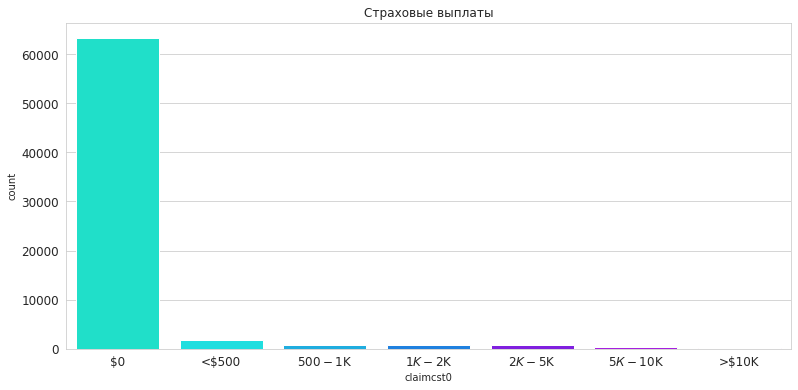

In [ ]:
order = ['$0', '<$500', '$500-$1K', '$1K-$2K', '$2K-$5K', '$5К-$10K', '>$10K'] 

plt.figure(figsize=(13, 6))
d = sns.countplot(x = df['claimcst0'].apply(condition), palette = custom_colors)
d.set_xticklabels(order, rotation=0)
d.set_title('Страховые выплаты')

# вывести кол-во над столбцами
labels = df['claimcst0'].apply(condition).value_counts().to_list()
labels_above_columns(labels)

Посмотрим на данные без нулевых выплат

NameError: ignored

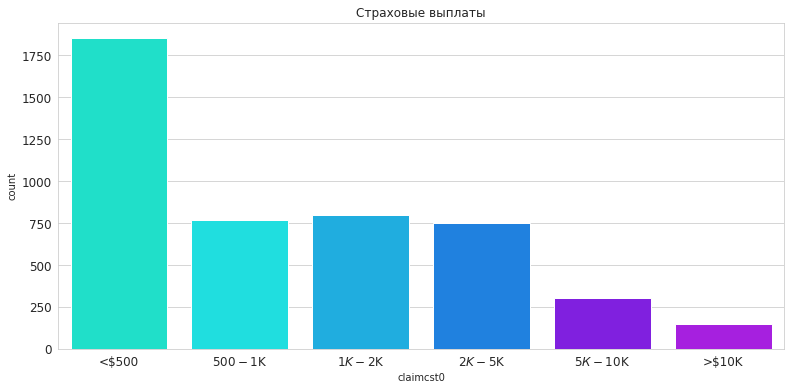

In [ ]:
order = ['<$500', '$500-$1K', '$1K-$2K', '$2K-$5K', '$5К-$10K', '>$10K']

plt.figure(figsize=(13, 6))
d = sns.countplot(x = df2[df2['claimcst0'] !=0]['claimcst0'].apply(condition), palette = custom_colors)
d.set_xticklabels(order, rotation=0)
d.set_title('Страховые выплаты')

# вывести кол-во над столбцами
labels = df['claimcst0'].apply(condition).value_counts().to_list()
labels_above_columns(labels)

Посмотрим на частоту различных кузовов машин

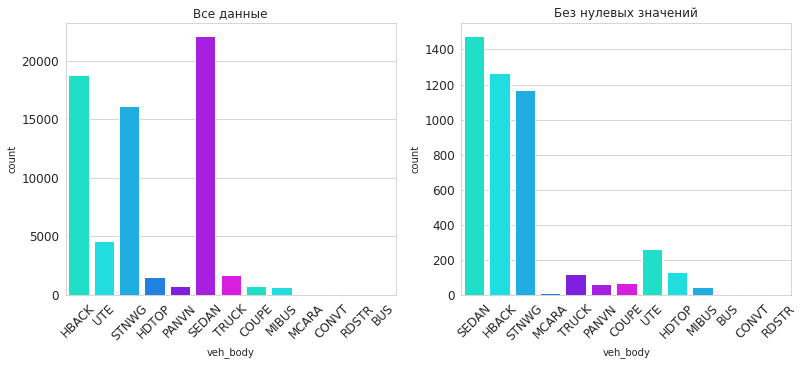

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2) # настраиваем полотна
fig.set_size_inches(13, 5)
g = sns.countplot(x='veh_body', data=df2, ax=ax1, palette = custom_colors) # строим первую столбчатую диаграмму
label = g.set_xticklabels(g.get_xticklabels(), rotation=45) # устанавливаем название корпусов автомобилей по оси X, указываем под каким углом отрисовать их
title = g.set_title('Все данные')
g = sns.countplot(x = 'veh_body', data = df2[df2['numclaims']>0], ax = ax2, palette = custom_colors) # строим вторую столбчатую диаграмму
label = g.set_xticklabels(g.get_xticklabels(), rotation=45) 
title = g.set_title('Без нулевых значений')

### Предобработка данных

В качестве прогнозируемой переменной, будем использовать `claimcst0`.

В качестве предикатов: `veh_body`, `veh_age`, `agecat`, `gender`, `area`, `veh_value`.



В категориальной переменной veh_body редкие кузова машин объединим в одну группу и назовём "other".

In [ ]:
df2['veh_value_cat'] = df2['claimcst0'].apply(condition) # распределеним страховые выплаты по интервалам

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Сгруппируем редкие кузова машин и объединим их в группу "others"

In [ ]:
series = pd.value_counts(df2.veh_body)   # посчитаем кол-во машин в разных корпусах
mask = (series/series.sum() * 100).lt(1) # посчитаем в процентном соотношении кол-во машин в разных корпусах; .lt(1) получим булеву маску, True если кол-во < 1
df2['veh_body'] = np.where(df2['veh_body'].isin(series[mask].index), 'Other', df2['veh_body']) # для корпусов с малым кол-ом поставим лейбл "other"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df3 = df2.astype({'veh_body': str, 'veh_age': str, 'gender': str, 'area': str, 'agecat': str, 'veh_value_cat': str}) # изменим тип данных на str

Разделим выборку на тренировочную и тестовую

In [ ]:
np.random.seed(42)
mask = np.random.rand(len(df3)) < 0.8
df_train = df3[mask]
df_test = df3[~mask]
print('Training data set length = ' + str(len(df_train)))
print('Testing data set length = ' + str(len(df_test)))

Training data set length = 54025
Testing data set length = 13401


Укажем, в каком столбце находятся лейблы и какие объясняющие переменные мы будем использовать для предсказания.

In [ ]:
expr = "claimcst0 ~ veh_value_cat+veh_body+veh_age+gender+area+agecat" 

[dmatrices](https://patsy.readthedocs.io/en/latest/quickstart.html?highlight=dmatrices#quickstart) вернет массив с лейблами и матрицу с фитчами, при создании которой использовалось one hot кодирование и добавляется столбец с единицами отвечающий за смещение (bias). 

In [ ]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [ ]:
X_train.head(3)

,Intercept,veh_value_cat[T.1],veh_value_cat[T.2],veh_value_cat[T.3],veh_value_cat[T.4],veh_value_cat[T.5],veh_value_cat[T.6],veh_body[T.HBACK],veh_body[T.HDTOP],veh_body[T.MIBUS],veh_body[T.Other],veh_body[T.PANVN],veh_body[T.SEDAN],veh_body[T.STNWG],veh_body[T.TRUCK],veh_body[T.UTE],veh_age[T.2],veh_age[T.3],veh_age[T.4],gender[T.M],area[T.B],area[T.C],area[T.D],area[T.E],area[T.F],agecat[T.2],agecat[T.3],agecat[T.4],agecat[T.5],agecat[T.6]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Тренировка модели

`var_power` это параметр $p$, который необходимо регулировать, чтобы получить лучший результат. Вначале поставим его рандомно.



Чтобы улучшить модель, мы можем найти оптимальный параметр `var_power` ($p$), часто это не тривиальная задача, но её можно упростить, используя функцию [`minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) из библиотеки [Scipy](https://docs.scipy.org/doc/), которая минимизирует скалярную функцию одной переменной. Чтобы показать как это работает, вначале установим случайное значение параметру `var_power`.

In [ ]:
# sm.families.Tweedie - https://www.statsmodels.org/0.9.0/generated/statsmodels.genmod.families.family.Tweedie.html
res = sm.GLM(y_train, X_train, family=sm.families.Tweedie(link=sm.families.links.log, var_power=1.1)).fit() # family укажем семейство распределений; 
print(res.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


                 Generalized Linear Model Regression Results                  
Dep. Variable:              claimcst0   No. Observations:                54025
Model:                            GLM   Df Residuals:                    53995
Model Family:                 Tweedie   Df Model:                           29
Link Function:                    log   Scale:                          5.1284
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 17 Nov 2020   Deviance:                   2.5183e+05
Time:                        18:17:02   Pearson chi2:                 2.77e+05
No. Iterations:                    31                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -26.7980   1095

В качестве метрики качества, возьмем $r^2$. 

$r^2 = 1 - \frac{RSS}{\sum \limits_{i=1}^n(y_i - \overline Y)^2}$, где

$RSS = \sum \limits_{i=1}^n(y_i - y_{pred_i})^2$

Видим, что у нас вышло хорошее качество модели.

In [ ]:
y_pred = res.predict(X_test).to_list()
r2_score(y_test, y_pred)

0.9165165474944557

Чтобы подобрать оптимальное значение `var_power`, воспользуемся функцией правдоподобия из библиотеки tweedie и минимизируем её, используя функцию `minimize_scalar`. Оптимальное значение `var_power`, лежит в `opt.x`

In [ ]:
def loglike_p(p):
    return -tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

opt = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), method='bounded')
print(opt)

     fun: 26100.348965442157
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 1.4276480268863827


In [ ]:
res2 = sm.GLM(y_train, X_train, family=sm.families.Tweedie(link=sm.families.links.log, var_power=opt.x)).fit()
print(res.summary())

def loglike_p(p):
    return -tweedie(mu=res2.mu, p=p, phi=res2.scale).logpdf(res2._endog).sum()

opt2 = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), method='bounded')
print(opt2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.


                 Generalized Linear Model Regression Results                  
Dep. Variable:              claimcst0   No. Observations:                54025
Model:                            GLM   Df Residuals:                    53995
Model Family:                 Tweedie   Df Model:                           29
Link Function:                    log   Scale:                          5.1284
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 17 Nov 2020   Deviance:                   2.5183e+05
Time:                        18:17:33   Pearson chi2:                 2.77e+05
No. Iterations:                    31                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -26.7980   1095

In [ ]:
y_pred = res2.predict(X_test).to_list()
r2_score(y_test, y_pred)

0.9147505536729288

Видим, что в нашем случае качество модели не изменилось, но так бывает не всегда! Если видим, что результат изменяется, то данный процесс повторяем иттерационно. Т.к. в нашем случае изменений нет, то оставим нашу модель как есть.

Давайте посмотрим на предсказания тех значений, где они не равный нулю, чтобы убедится, что построенная модель работает корректно.

In [ ]:
y_test['pred'] = np.round(np.array(y_pred), 2)
y_test[y_test.claimcst0 != 0]

,claimcst0,pred
183,9424.349976,7874.64
241,369.180000,310.28
387,937.559996,705.13
456,2659.369995,3074.62
571,782.359999,739.00
...,...,...
67566,3054.070000,2902.53
67669,1552.599998,1362.87
67747,468.179999,339.94
67846,2807.929993,3288.49


Видим, что модель работает и её можно использовать для моделирования страховых выплат.

### Сравним модель Tweedie и линейную регрессию

In [ ]:
# запишем файл с результатами измерений
import csv
order = ['r2', 'mse', 'mae']
def write_csv(data, order):
  with open('results.csv', 'a') as f:
    writer = csv.DictWriter(f, fieldnames=order)
    writer.writerow(data)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# тренировка моделей
ridge = Ridge().fit(X_train, y_train)
tweedie = sm.GLM(y_train, X_train, family=sm.families.Tweedie(link=sm.families.links.log, var_power=1.1)).fit()

models = [ridge, tweedie]

metrics = {'r2': r2_score, 
           'mse': mean_squared_error,
           'mae': mean_absolute_error}

# измерим метрики
for model in models:
  metric_res = {}
  for key in metrics.keys():
    metric_res[key] = round(metrics[key](model.predict(X_test), y_test.claimcst0), 2)
  write_csv(metric_res, order)

# откроем посмотреть результат
results = pd.read_csv('results.csv', names = order)
results.index = ['linear', 'tweedie']
results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """


,r2,mse,mae
linear,0.92,92964.22,39.02
tweedie,0.92,90841.13,30.58


Настройка регуляризации в statsmodel.

### Источники и дополнительные материалы

Материал создан на основе статьи: [ссылка](https://towardsdatascience.com/insurance-risk-pricing-tweedie-approach-1d71207268fc)

Библиотека Tweedie: [ссылка](https://github.com/thequackdaddy/tweedie)

Пример использования библиотекой Tweedie: [ссылка](https://github.com/thequackdaddy/tweedie/blob/master/example/tweedie_demo.ipynb)

Функция минимизации minimize_scalar из Scipy:  [ссылка](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html)

Ноутбук с реализацией XGBOOST + Tweedie распределение: [ссылка](https://colab.research.google.com/gist/ajaytiwari-isb/dd78b382c44d69332574c381e016af2a/tweedie-regression.ipynb#scrollTo=PAghfX5EdjZ2)

Функция потерь распределения Tweedie: [ссылка](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f)

Удобная обертка dmatrix для формирования тренировочных и тестовых данных: [ссылка](https://patsy.readthedocs.io/en/latest/quickstart.html?highlight=dmatrices#quickstart)